In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as Func
from torch.autograd import Variable
from torchinfo import summary

from sklearn.preprocessing import MinMaxScaler

In [2]:
with open("datasets/oracle_data.pickle", "rb") as handle:
    oracle_data = pickle.load(handle)

with open("datasets/oracle_reversed_data.pickle", "rb") as handle:
    oracle_reversed_data = pickle.load(handle)

with open("datasets/oracle_random_data.pickle", "rb") as handle:
    oracle_random_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data.pickle", "rb") as handle:
    oracle_reversed_random_data = pickle.load(handle)

with open("datasets/random_data.pickle", "rb") as handle:
    random_data = pickle.load(handle)

with open("datasets/tmaze_random_reverse_data.pickle", "rb") as handle:
    tmaze_random_reverse_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data_small.pickle", "rb") as handle:
    oracle_reversed_random_data_small = pickle.load(handle)

In [3]:
actions = oracle_reversed_data['actions']
actions = [[i] for i in actions]

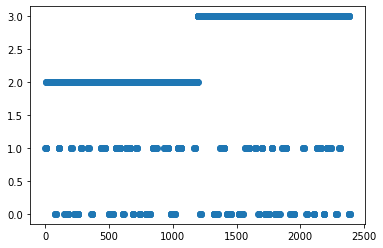

In [4]:
plt.plot(actions, "o")
plt.show()

In [69]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i : (i + seq_length)]
        _y = data[i + seq_length]  # _y = data[i+seq_length] (target)
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)  # train, val. data

def create_data(seq_length, data, shuffle = True):
    
    actions = data['actions']
    actions = [[i] for i in actions]
    training_data = actions

    x, y = sliding_windows(training_data, seq_length)

    # one method of performing the training and validation split
    train_size = int(len(y) * 0.80)
    test_size = len(y) - train_size


    # shuffle data first before splitting
    if shuffle:
        idx_shuf = list(range(len(y)))
        random.shuffle(idx_shuf)
        x = [x[i] for i in idx_shuf]
        y = [y[i] for i in idx_shuf]

    # split data
    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

    testX = Variable(torch.Tensor(np.array(x[train_size : len(x)])))
    testY = Variable(torch.Tensor(np.array(y[train_size : len(y)])))
    
    return trainX, trainY, testX, testY


training_data = actions


seq_length = 20
shuffle = True

x, y = sliding_windows(training_data, seq_length)

# one method of performing the training and validation split
train_size = int(len(y) * 0.80)
test_size = len(y) - train_size


# shuffle data first before splitting
if shuffle:
    idx_shuf = list(range(len(y)))
    random.shuffle(idx_shuf)
    x = [x[i] for i in idx_shuf]
    y = [y[i] for i in idx_shuf]

# split data
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size : len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size : len(y)])))

In [70]:
k = 6
print('sequence:', x[k])
print('label:', y[k])

sequence: [[2]
 [2]
 [2]
 [2]
 [2]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]]
label: [2]


In [124]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)

        return out
    
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 300
num_layers = 1

num_classes = 4

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

In [125]:
value = 0

test_input = trainX[value:value+1]
print("input length:", len(test_input[0]))
print("input (trainX):", test_input)

outputs = lstm(test_input)
print(outputs)

print("outputs:", outputs)
_, rounded_opt = torch.max(outputs, 1)
print("output rounded:", rounded_opt)
print("labels:", trainY[value:value+1])

print("")

outputs = lstm(trainX)

print("length input (trainX):", len(trainX))
print("length outputs:", len(outputs))
print("length labels:", len(trainY))

print("")
print("SUMMARY LSTM \n", summary(lstm, (1908, 1, 1), device="cpu"))

input length: 20
input (trainX): tensor([[[2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.],
         [2.]]])
tensor([[ 0.0029,  0.0327, -0.0198, -0.0015]], grad_fn=<AddmmBackward0>)
outputs: tensor([[ 0.0029,  0.0327, -0.0198, -0.0015]], grad_fn=<AddmmBackward0>)
output rounded: tensor([1])
labels: tensor([[2.]])

length input (trainX): 1895
length outputs: 1895
length labels: 1895

SUMMARY LSTM 
Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [1908, 4]                 --
├─LSTM: 1-1                              [1908, 1, 300]            363,600
├─Linear: 1-2                            [1908, 4]                 1,204
Total params: 364,804
Trainable params: 364,804
Non-trainable params: 0
Total mul

In [82]:
def plot_losses(test_loss, train_loss, num_epochs):
    
    for i in range(len(train_loss)):
        train_loss[i] = train_loss[i].item()
    
    font = 24
    hfont = {'fontname':'Helvetica'}
        
    plt.rcParams["figure.figsize"] = 20, 6
    plt.rcParams['axes.titlepad'] = 13 
    plt.rcParams['xtick.major.pad']='8' # axis distance
    plt.rcParams['ytick.major.pad']='8'
    
    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    
    with plt.style.context("seaborn-darkgrid"):
        
        plt.rcParams.update({"font.size": font})
        plt.plot(test_loss, color="slategray", linewidth=2, label="Training Loss")
        plt.plot(train_loss, color="red", linewidth=2, label="Validation Loss")
        plt.legend(fontsize=font)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Loss")
        
        # plt.savefig('difficult_env_loss_epochs.pdf', bbox_inches="tight")
        plt.show()

def plot_euclidean_distance(train_dis, test_dis, num_epochs):
    
    
    #for i in range(len(train_dis)):
    #    train_dis[i] = train_dis[i].item()
    
    #for i in range(len(test_dis)):
    #    test_dis[i] = test_dis[i].item()  

    font = 24
    hfont = {'fontname':'Helvetica'}
        
    plt.rcParams["figure.figsize"] = 20, 6
    plt.rcParams['axes.titlepad'] = 13 
    plt.rcParams['xtick.major.pad']='8' # axis distance
    plt.rcParams['ytick.major.pad']='8'
    
    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    plt.rcParams.update({"font.size": font})

    with plt.style.context("seaborn-darkgrid"):
        plt.plot(train_dis, label="Training", linewidth=3, color="tab:blue")
        plt.plot(test_dis, c='indianred', label="Validation", linewidth=3)
        plt.title("Difficult Environment", fontsize=font)
        plt.legend(fontsize=font)
        plt.xlabel("Epochs", fontsize=font, **hfont)
        plt.ylabel("Accuracy", fontsize=font, **hfont)
        
        plt.xlim(xmax = num_epochs+5, xmin = -5)
        
        #plt.savefig('difficult_env_euclidean_distance_epochs.pdf', bbox_inches="tight")
        
        plt.show()

hidden size is  100
Epoch: 0, train loss: 1.38341, train acc: 0.44644, test loss: 1.38350, test acc: 0.44515
Epoch: 25, train loss: 1.34189, train acc: 0.41689, test loss: 1.34277, test acc: 0.41561
Epoch: 50, train loss: 1.29121, train acc: 0.41689, test loss: 1.29307, test acc: 0.41561
Epoch: 75, train loss: 1.21175, train acc: 0.41741, test loss: 1.21495, test acc: 0.41983
Epoch: 100, train loss: 1.13255, train acc: 0.41741, test loss: 1.13594, test acc: 0.41983
Epoch: 125, train loss: 1.10339, train acc: 0.47757, test loss: 1.10769, test acc: 0.47046
Epoch: 150, train loss: 1.05482, train acc: 0.64380, test loss: 1.06060, test acc: 0.62025
Epoch: 175, train loss: 0.90072, train acc: 0.76781, test loss: 0.89860, test acc: 0.76582
Epoch: 200, train loss: 0.77465, train acc: 0.76728, test loss: 0.76308, test acc: 0.77848
Epoch: 225, train loss: 0.71713, train acc: 0.78892, test loss: 0.71101, test acc: 0.79325
Epoch: 250, train loss: 0.66581, train acc: 0.79736, test loss: 0.66508, te

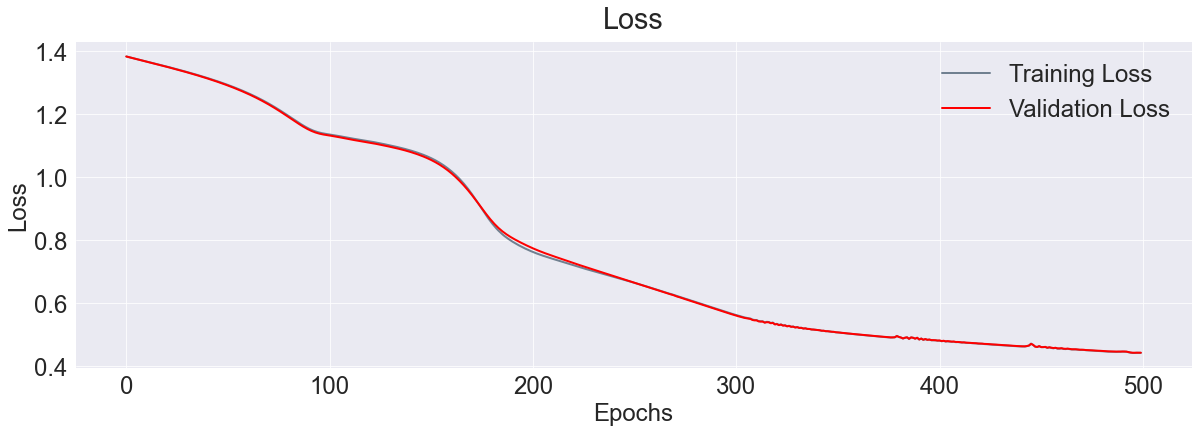

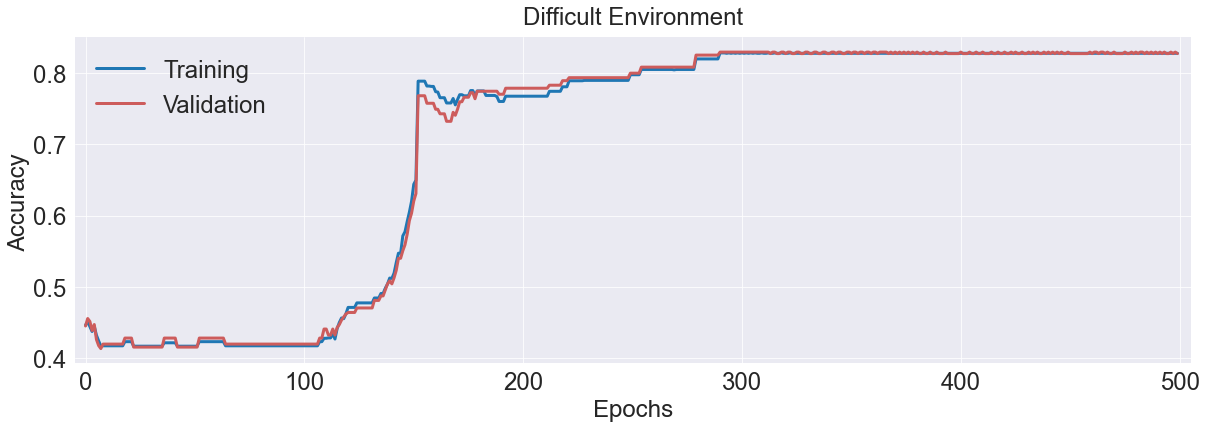

hidden size is  200
Epoch: 0, train loss: 1.41287, train acc: 0.03113, test loss: 1.41251, test acc: 0.04852
Epoch: 25, train loss: 1.34626, train acc: 0.41319, test loss: 1.34695, test acc: 0.40928
Epoch: 50, train loss: 1.26099, train acc: 0.74301, test loss: 1.26285, test acc: 0.71308
Epoch: 75, train loss: 1.13682, train acc: 0.41741, test loss: 1.13315, test acc: 0.41983
Epoch: 100, train loss: 1.09132, train acc: 0.44749, test loss: 1.09190, test acc: 0.45781
Epoch: 125, train loss: 0.98226, train acc: 0.77150, test loss: 0.98613, test acc: 0.75527
Epoch: 150, train loss: 0.72235, train acc: 0.78100, test loss: 0.72271, test acc: 0.78903
Epoch: 175, train loss: 0.65851, train acc: 0.78945, test loss: 0.66014, test acc: 0.79325
Epoch: 200, train loss: 0.59642, train acc: 0.80422, test loss: 0.60167, test acc: 0.80591
Epoch: 225, train loss: 0.53550, train acc: 0.82744, test loss: 0.53733, test acc: 0.82911
Epoch: 250, train loss: 0.53142, train acc: 0.82691, test loss: 0.53620, te

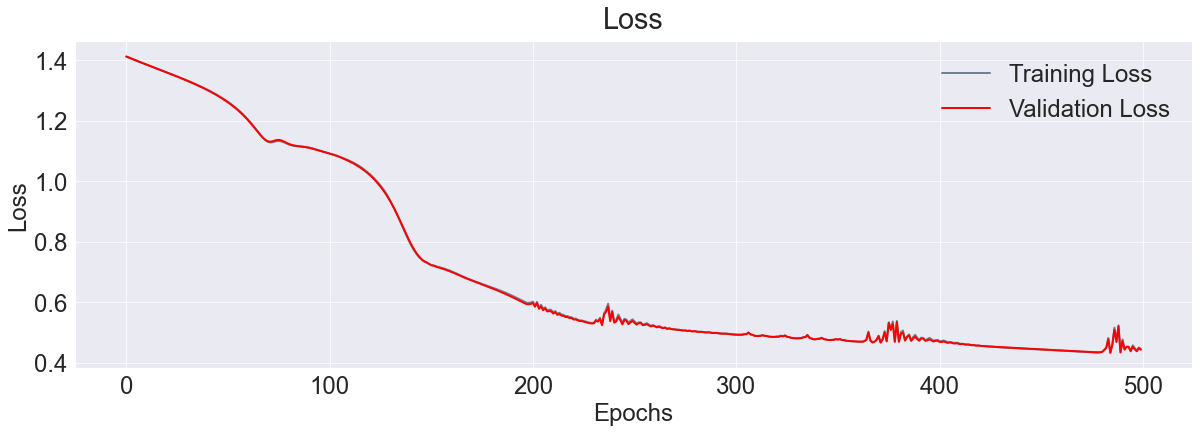

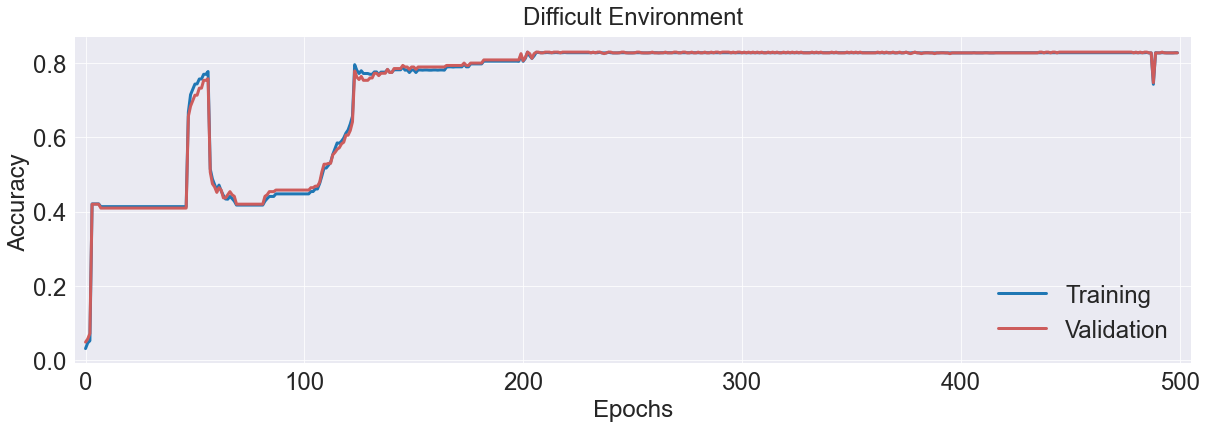

hidden size is  300
Epoch: 0, train loss: 1.37246, train acc: 0.48338, test loss: 1.37194, test acc: 0.47679
Epoch: 25, train loss: 1.27926, train acc: 0.41741, test loss: 1.28040, test acc: 0.41983
Epoch: 50, train loss: 1.13734, train acc: 0.41741, test loss: 1.13473, test acc: 0.41983
Epoch: 75, train loss: 1.09638, train acc: 0.42797, test loss: 1.09742, test acc: 0.44093
Epoch: 100, train loss: 0.96274, train acc: 0.76412, test loss: 0.96990, test acc: 0.74473
Epoch: 125, train loss: 0.70270, train acc: 0.78100, test loss: 0.71221, test acc: 0.78903
Epoch: 150, train loss: 0.60883, train acc: 0.80475, test loss: 0.61858, test acc: 0.80802
Epoch: 175, train loss: 0.53591, train acc: 0.82744, test loss: 0.54080, test acc: 0.82911
Epoch: 200, train loss: 0.52218, train acc: 0.81847, test loss: 0.52468, test acc: 0.82278
Epoch: 225, train loss: 0.49873, train acc: 0.82744, test loss: 0.50020, test acc: 0.82700
Epoch: 250, train loss: 0.47831, train acc: 0.82744, test loss: 0.47769, te

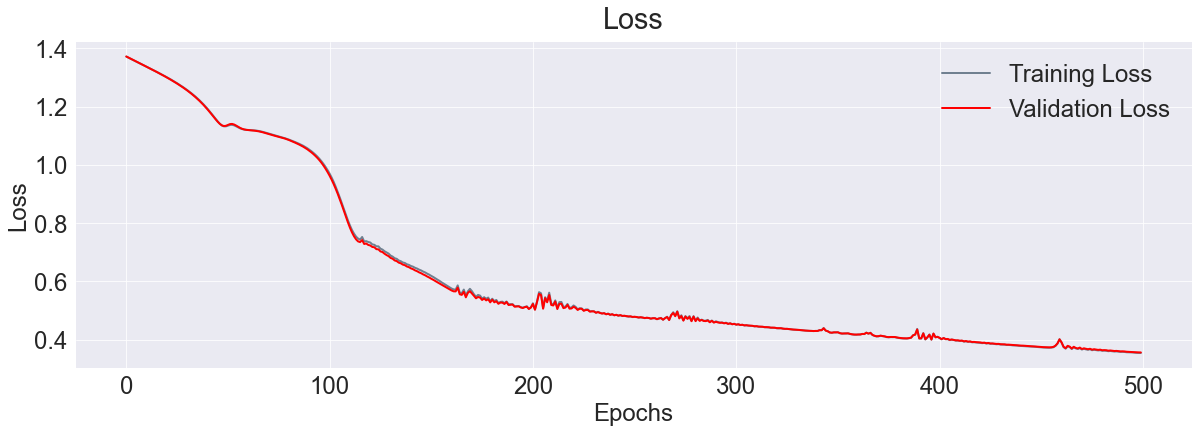

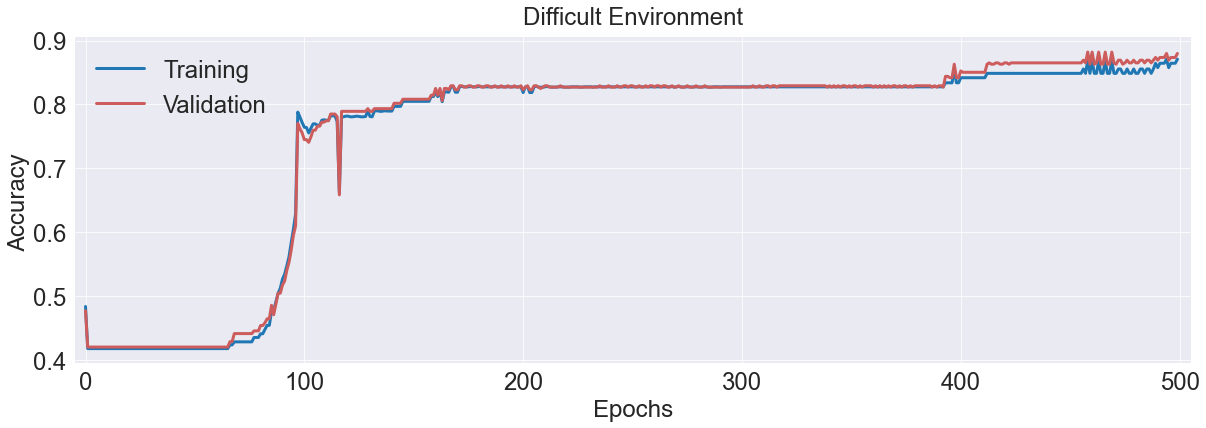

hidden size is  400
Epoch: 0, train loss: 1.38727, train acc: 0.08496, test loss: 1.38709, test acc: 0.09072
Epoch: 25, train loss: 1.26579, train acc: 0.41741, test loss: 1.26759, test acc: 0.41983
Epoch: 50, train loss: 1.12124, train acc: 0.41741, test loss: 1.12048, test acc: 0.41983
Epoch: 75, train loss: 1.06059, train acc: 0.49077, test loss: 1.06309, test acc: 0.48734
Epoch: 100, train loss: 0.71472, train acc: 0.78997, test loss: 0.72282, test acc: 0.79325
Epoch: 125, train loss: 0.59574, train acc: 0.81266, test loss: 0.60435, test acc: 0.81435
Epoch: 150, train loss: 0.53372, train acc: 0.82744, test loss: 0.53813, test acc: 0.82911
Epoch: 175, train loss: 0.51253, train acc: 0.82744, test loss: 0.51648, test acc: 0.82911
Epoch: 200, train loss: 0.49346, train acc: 0.82744, test loss: 0.49624, test acc: 0.82700
Epoch: 225, train loss: 0.49659, train acc: 0.82691, test loss: 0.49851, test acc: 0.82700
Epoch: 250, train loss: 0.47275, train acc: 0.82744, test loss: 0.47235, te

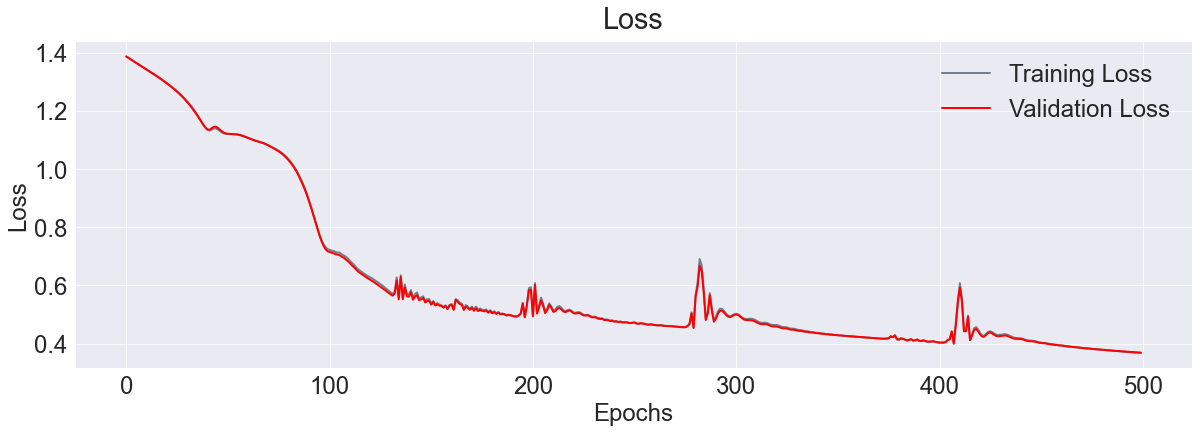

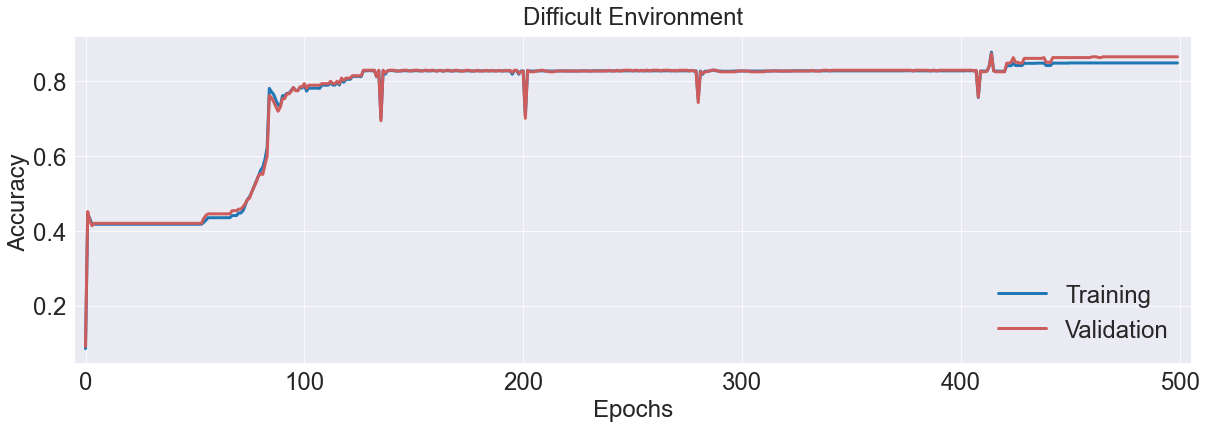

In [119]:
"""
best value: 0.07111 (hidden size of 20) - but overall little to no diff.
best value: 0.06789 (with a seq. length of 20)
increasing the length of the sequence length concidered 
for making the next decision, the better the resulting prediction
criterion = torch.nn.MSELoss()  # MSELoss - regression, CrossEntropyLoss for labels
"""

def train_lstm(num_epochs, trainX, trainY, testX, testY):
    
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
    
    train_loss_collector = []
    train_acc_collector = []
    test_loss_collector = []
    test_acc_collector = []
    
    # Train the model
    for epoch in range(num_epochs):

        train_correct = 0
        train_total = 0

        optimizer.zero_grad()
        outputs = lstm(trainX)
        labels = trainY.to(torch.long)
        labels = labels[:, 0]
        loss = criterion(outputs, labels)
        loss.backward()

        # compute train acc
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        train_acc = correct / len(trainX)
        
        # test set
        with torch.no_grad():
            outputs = lstm(testX)
            labels = testY.to(torch.long)
            labels = labels[:, 0]
            loss_test = criterion(outputs, labels)

            # compute test acc
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            test_acc = correct / len(testX)
        
        train_loss_collector.append(loss)
        train_acc_collector.append(train_acc)
        test_loss_collector.append(loss_test)
        test_acc_collector.append(test_acc)

        optimizer.step()
        if epoch % (num_epochs/20) == 0:
            print("Epoch: %d, train loss: %1.5f, train acc: %1.5f, test loss: %1.5f, test acc: %1.5f" % (epoch, loss.item(), train_acc, loss_test.item(), test_acc))
    return train_loss_collector, train_acc_collector, test_loss_collector, test_acc_collector


for i in range(1, 5):
    
    hidden_size = 100*i
    learning_rate = 0.0001
    num_epochs = 500
    
    print('hidden size is ', i*100)
    train_loss_collector, train_acc_collector, test_loss_collector, test_acc_collector = train_lstm(num_epochs, trainX, trainY, testX, testY)
    plot_losses(test_loss_collector, train_loss_collector, num_epochs)
    plot_euclidean_distance(train_acc_collector, test_acc_collector, num_epochs)



sequence lenth 1 easy environment
Epoch: 0, train loss: 1.37343, train acc: 0.51832, test loss: 1.38936, test acc: 0.00000
Epoch: 25, train loss: 1.20038, train acc: 0.51832, test loss: 1.21919, test acc: 0.00000
Epoch: 50, train loss: 1.04454, train acc: 0.51832, test loss: 1.12736, test acc: 0.00000
Epoch: 75, train loss: 0.99592, train acc: 0.51832, test loss: 1.08629, test acc: 0.00000
Epoch: 100, train loss: 0.93304, train acc: 0.81571, test loss: 0.98223, test acc: 0.81172
Epoch: 125, train loss: 0.84624, train acc: 0.81571, test loss: 0.87012, test acc: 0.81172
Epoch: 150, train loss: 0.74571, train acc: 0.81571, test loss: 0.76417, test acc: 0.81172
Epoch: 175, train loss: 0.65335, train acc: 0.87853, test loss: 0.68208, test acc: 0.88494
Epoch: 200, train loss: 0.58518, train acc: 0.87853, test loss: 0.63633, test acc: 0.88494
Epoch: 225, train loss: 0.54307, train acc: 0.87853, test loss: 0.62097, test acc: 0.88494
Epoch: 250, train loss: 0.52003, train acc: 0.87853, test lo

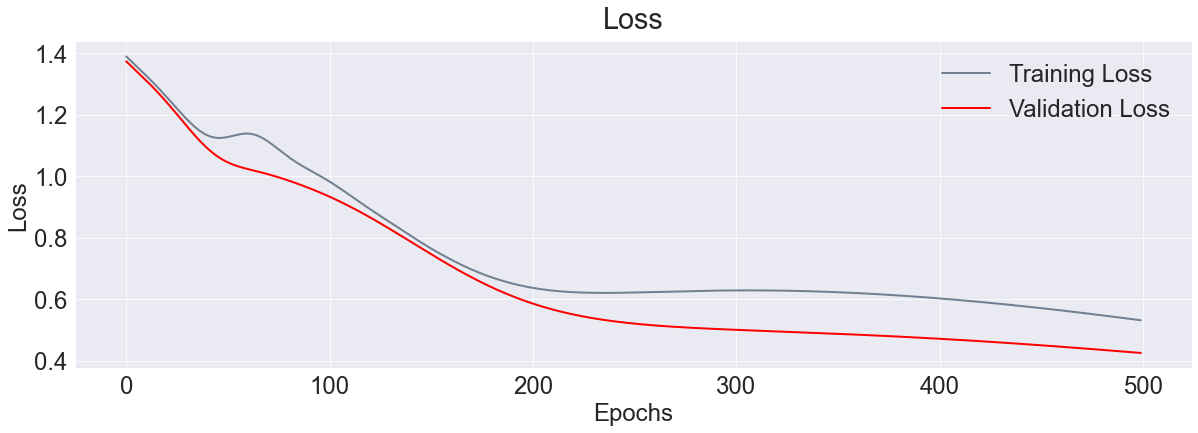

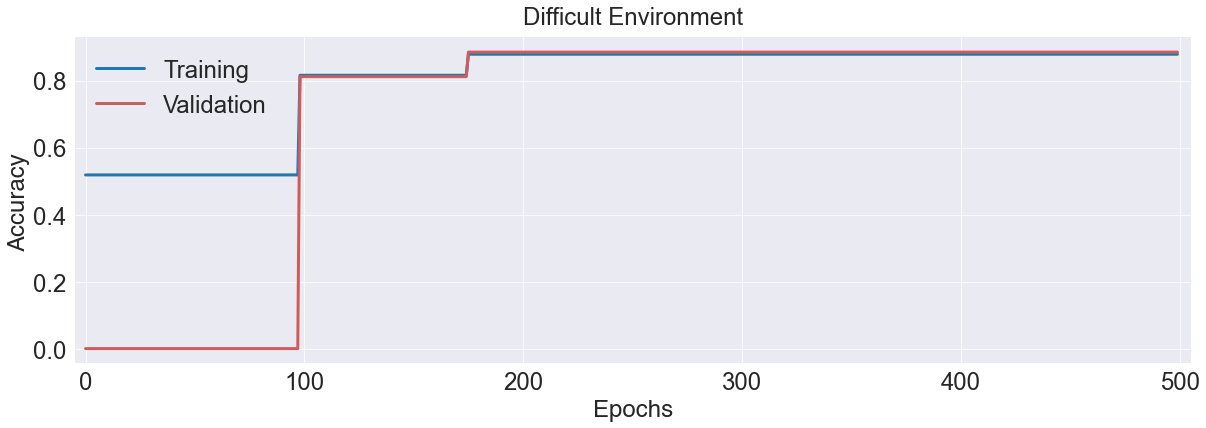


sequence lenth 11 easy environment
Epoch: 0, train loss: 1.40271, train acc: 0.31125, test loss: 1.34554, test acc: 0.83613
Epoch: 25, train loss: 0.90955, train acc: 0.72660, test loss: 1.02465, test acc: 0.60924
Epoch: 50, train loss: 0.63782, train acc: 0.77129, test loss: 0.62920, test acc: 0.71218
Epoch: 75, train loss: 0.50692, train acc: 0.82860, test loss: 0.48719, test acc: 0.84244
Epoch: 100, train loss: 0.43043, train acc: 0.85962, test loss: 0.33881, test acc: 0.89496
Epoch: 125, train loss: 0.32820, train acc: 0.90379, test loss: 0.29436, test acc: 0.89496
Epoch: 150, train loss: 0.28283, train acc: 0.91903, test loss: 0.25565, test acc: 0.90966
Epoch: 175, train loss: 0.27598, train acc: 0.91851, test loss: 0.25679, test acc: 0.90966
Epoch: 200, train loss: 0.24768, train acc: 0.92850, test loss: 0.22857, test acc: 0.90966
Epoch: 225, train loss: 0.23180, train acc: 0.93796, test loss: 0.21657, test acc: 0.93487
Epoch: 250, train loss: 2.92857, train acc: 0.57992, test l

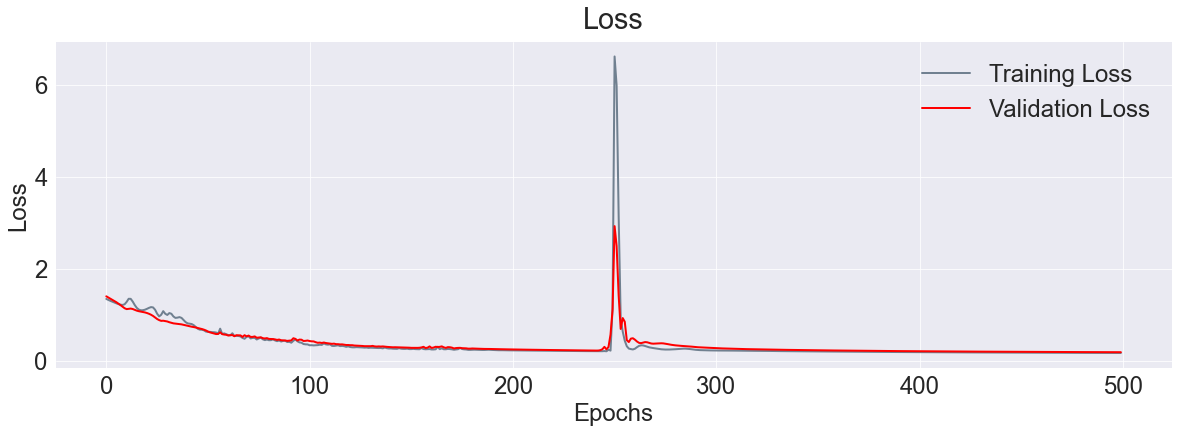

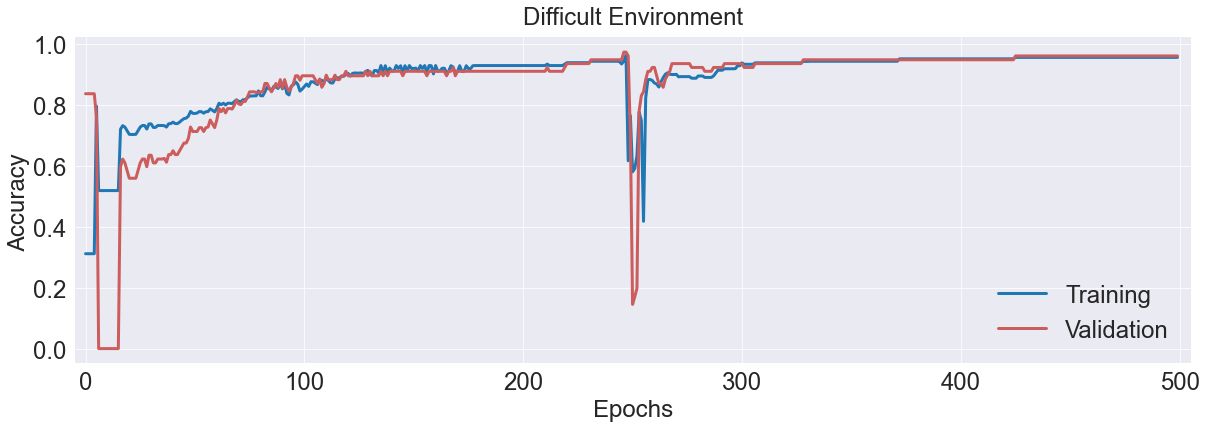


sequence lenth 21 easy environment
Epoch: 0, train loss: 1.37100, train acc: 0.31362, test loss: 1.35794, test acc: 0.83544
Epoch: 25, train loss: 0.80109, train acc: 0.74234, test loss: 0.90651, test acc: 0.67089
Epoch: 50, train loss: 0.55391, train acc: 0.82629, test loss: 0.51072, test acc: 0.83544
Epoch: 75, train loss: 0.48356, train acc: 0.82524, test loss: 0.45079, test acc: 0.83544
Epoch: 100, train loss: 0.42653, train acc: 0.84477, test loss: 0.38791, test acc: 0.87975
Epoch: 125, train loss: 0.36226, train acc: 0.84424, test loss: 0.30187, test acc: 0.87975
Epoch: 150, train loss: 0.37143, train acc: 0.87487, test loss: 0.27005, test acc: 0.89451
Epoch: 175, train loss: 0.30210, train acc: 0.88860, test loss: 0.24621, test acc: 0.90928
Epoch: 200, train loss: 0.29664, train acc: 0.89440, test loss: 0.22372, test acc: 0.90928
Epoch: 225, train loss: 0.26385, train acc: 0.89176, test loss: 0.19877, test acc: 0.89241
Epoch: 250, train loss: 0.22418, train acc: 0.92555, test l

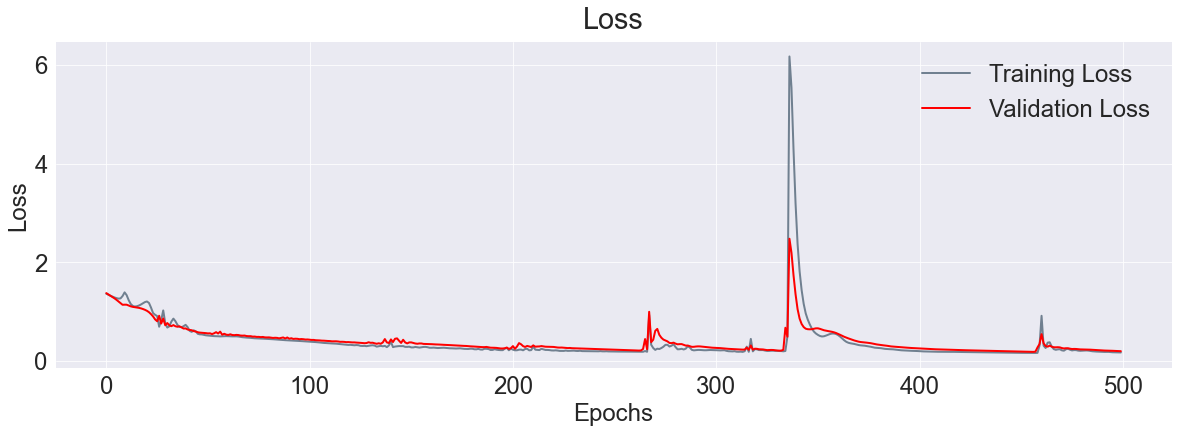

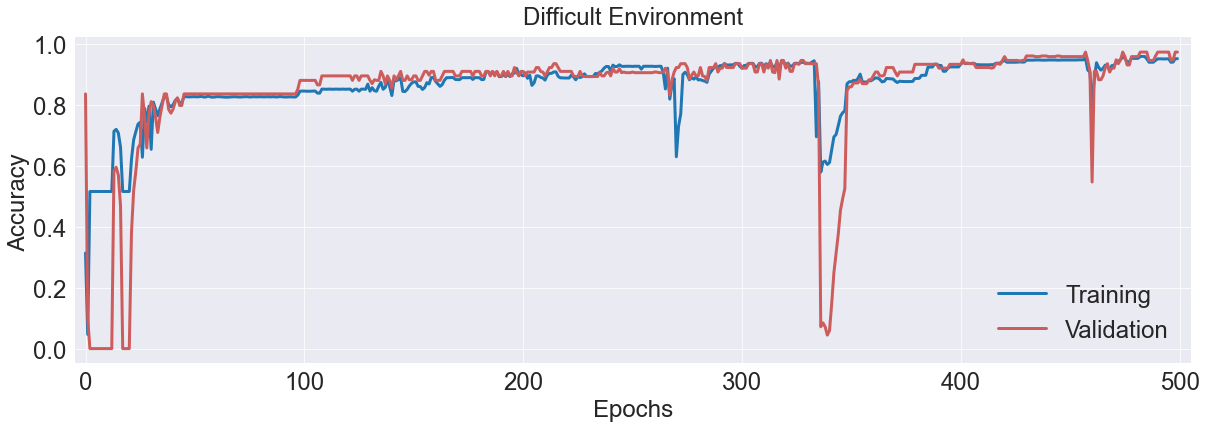


sequence lenth 1 medium environment
Epoch: 0, train loss: 1.39145, train acc: 0.31026, test loss: 1.37001, test acc: 0.35833
Epoch: 25, train loss: 1.37161, train acc: 0.33903, test loss: 1.41424, test acc: 0.23000
Epoch: 50, train loss: 1.36214, train acc: 0.33903, test loss: 1.41422, test acc: 0.23000
Epoch: 75, train loss: 1.35757, train acc: 0.29942, test loss: 1.42342, test acc: 0.24833
Epoch: 100, train loss: 1.35363, train acc: 0.29942, test loss: 1.42201, test acc: 0.24833
Epoch: 125, train loss: 1.34529, train acc: 0.41910, test loss: 1.41427, test acc: 0.35667
Epoch: 150, train loss: 1.32948, train acc: 0.41910, test loss: 1.40010, test acc: 0.35667
Epoch: 175, train loss: 1.30852, train acc: 0.40992, test loss: 1.38419, test acc: 0.35667
Epoch: 200, train loss: 1.29364, train acc: 0.40992, test loss: 1.37895, test acc: 0.35667
Epoch: 225, train loss: 1.28920, train acc: 0.40992, test loss: 1.38176, test acc: 0.35667
Epoch: 250, train loss: 1.28711, train acc: 0.40992, test 

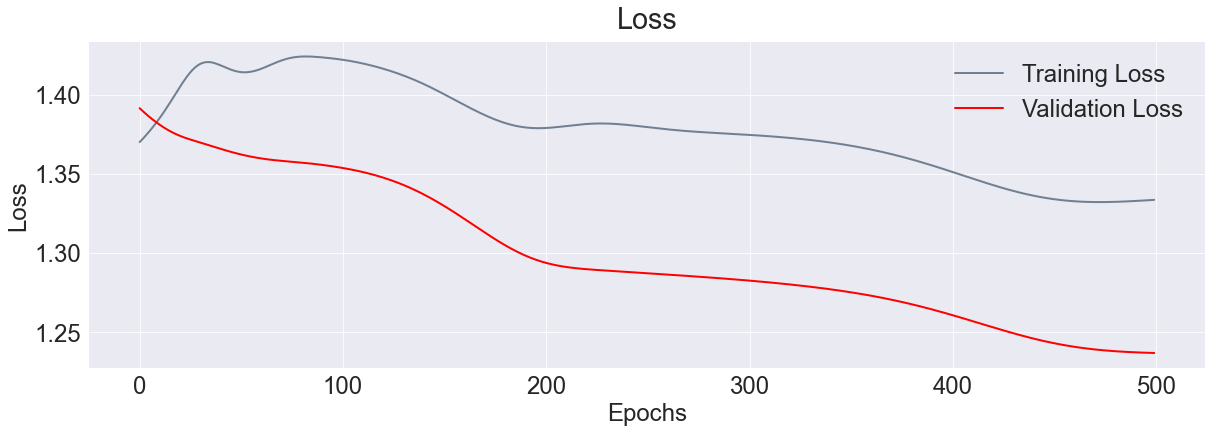

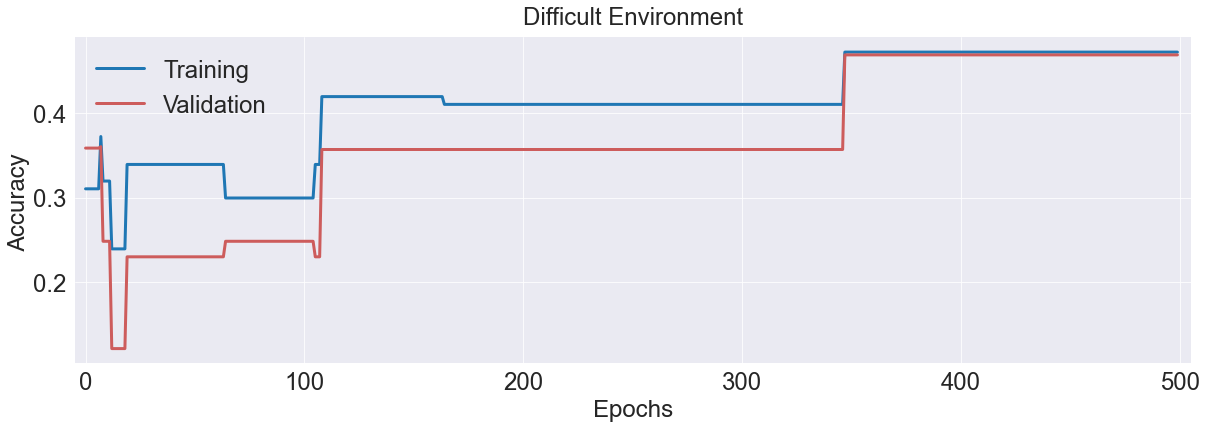


sequence lenth 11 medium environment
Epoch: 0, train loss: 1.38600, train acc: 0.28577, test loss: 1.38661, test acc: 0.15552
Epoch: 25, train loss: 1.35747, train acc: 0.29372, test loss: 1.40163, test acc: 0.20234
Epoch: 50, train loss: 1.27068, train acc: 0.37490, test loss: 1.35334, test acc: 0.29431
Epoch: 75, train loss: 0.96633, train acc: 0.57782, test loss: 0.91495, test acc: 0.64214
Epoch: 100, train loss: 0.84842, train acc: 0.64393, test loss: 0.83877, test acc: 0.67559
Epoch: 125, train loss: 0.78363, train acc: 0.69623, test loss: 0.78393, test acc: 0.68896
Epoch: 150, train loss: 0.72778, train acc: 0.72803, test loss: 0.73785, test acc: 0.71906
Epoch: 175, train loss: 0.68416, train acc: 0.72803, test loss: 0.70677, test acc: 0.72241
Epoch: 200, train loss: 0.64100, train acc: 0.74393, test loss: 0.68059, test acc: 0.72074
Epoch: 225, train loss: 0.60211, train acc: 0.75523, test loss: 0.65920, test acc: 0.72241
Epoch: 250, train loss: 0.67324, train acc: 0.72301, test

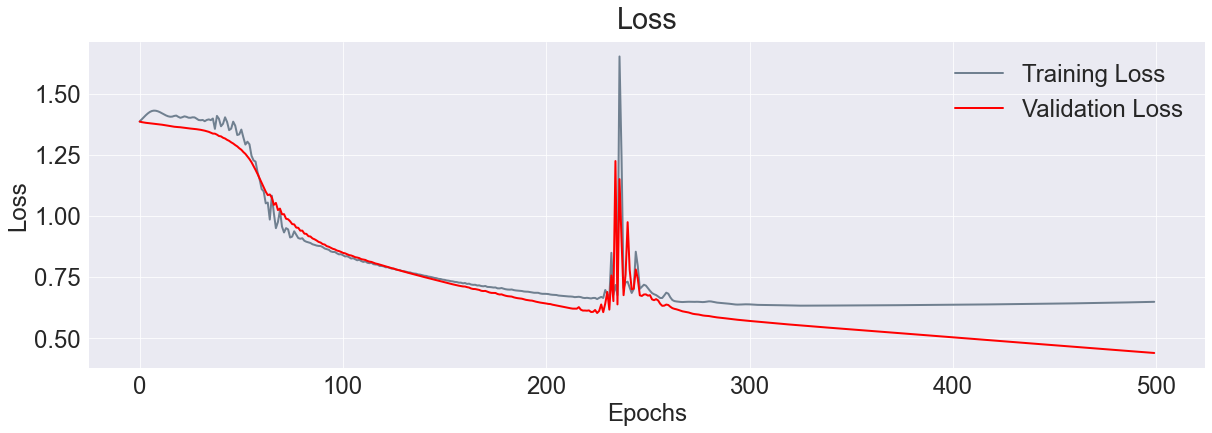

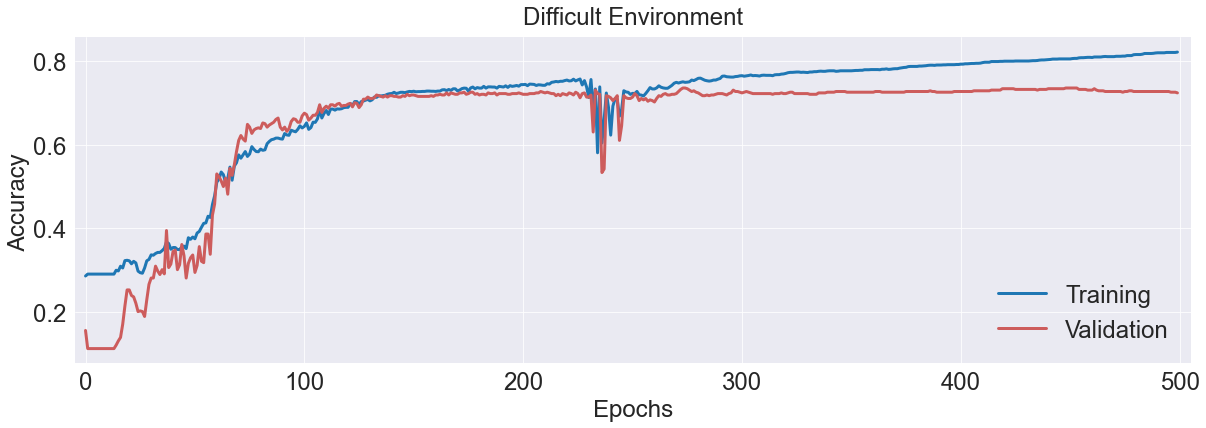


sequence lenth 21 medium environment
Epoch: 0, train loss: 1.39221, train acc: 0.22082, test loss: 1.37091, test acc: 0.39430
Epoch: 25, train loss: 1.35886, train acc: 0.33081, test loss: 1.41139, test acc: 0.20973
Epoch: 50, train loss: 1.33654, train acc: 0.35726, test loss: 1.37158, test acc: 0.31544
Epoch: 75, train loss: 1.24969, train acc: 0.45424, test loss: 1.33986, test acc: 0.34899
Epoch: 100, train loss: 0.99959, train acc: 0.55793, test loss: 1.02008, test acc: 0.53859
Epoch: 125, train loss: 0.88064, train acc: 0.63224, test loss: 0.86388, test acc: 0.62081
Epoch: 150, train loss: 0.80920, train acc: 0.68388, test loss: 0.82013, test acc: 0.69295
Epoch: 175, train loss: 0.75596, train acc: 0.72124, test loss: 0.78535, test acc: 0.71812
Epoch: 200, train loss: 0.70416, train acc: 0.74307, test loss: 0.76178, test acc: 0.71309
Epoch: 225, train loss: 0.66177, train acc: 0.75651, test loss: 0.74054, test acc: 0.69631
Epoch: 250, train loss: 1.00735, train acc: 0.56759, test

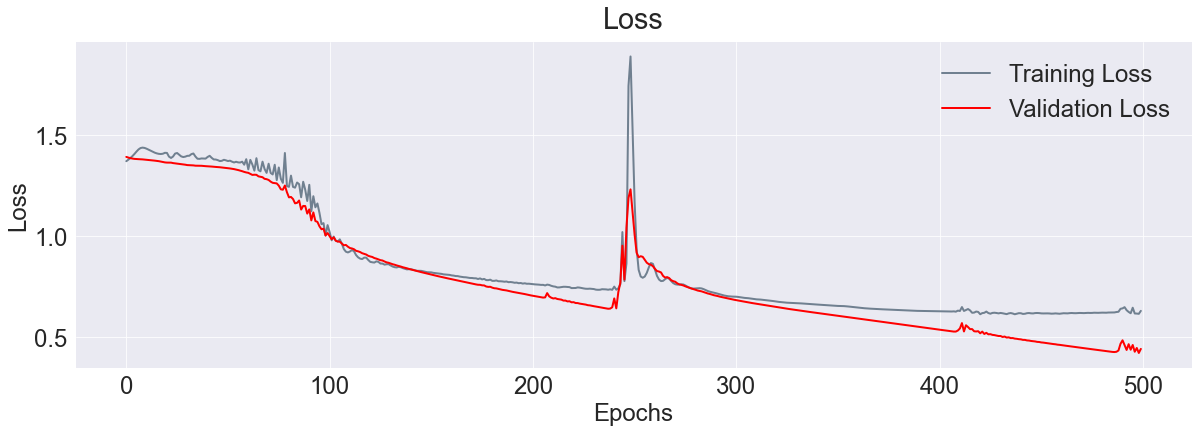

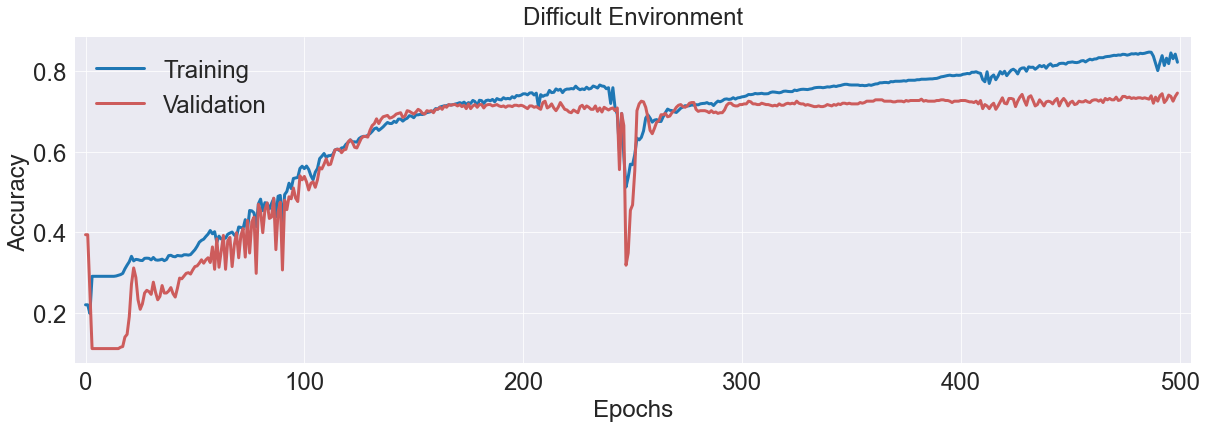


sequence lenth 1 difficult environment
Epoch: 0, train loss: 1.38806, train acc: 0.24030, test loss: 1.38703, test acc: 0.25250
Epoch: 25, train loss: 1.38527, train acc: 0.26909, test loss: 1.38713, test acc: 0.24500
Epoch: 50, train loss: 1.38518, train acc: 0.26909, test loss: 1.38698, test acc: 0.24500
Epoch: 75, train loss: 1.38515, train acc: 0.26909, test loss: 1.38683, test acc: 0.24500
Epoch: 100, train loss: 1.38512, train acc: 0.26909, test loss: 1.38679, test acc: 0.24500
Epoch: 125, train loss: 1.38507, train acc: 0.26909, test loss: 1.38678, test acc: 0.24500
Epoch: 150, train loss: 1.38497, train acc: 0.26909, test loss: 1.38673, test acc: 0.24500
Epoch: 175, train loss: 1.38481, train acc: 0.26909, test loss: 1.38667, test acc: 0.24500
Epoch: 200, train loss: 1.38461, train acc: 0.26909, test loss: 1.38665, test acc: 0.24500
Epoch: 225, train loss: 1.38451, train acc: 0.26909, test loss: 1.38670, test acc: 0.24500
Epoch: 250, train loss: 1.38449, train acc: 0.26909, te

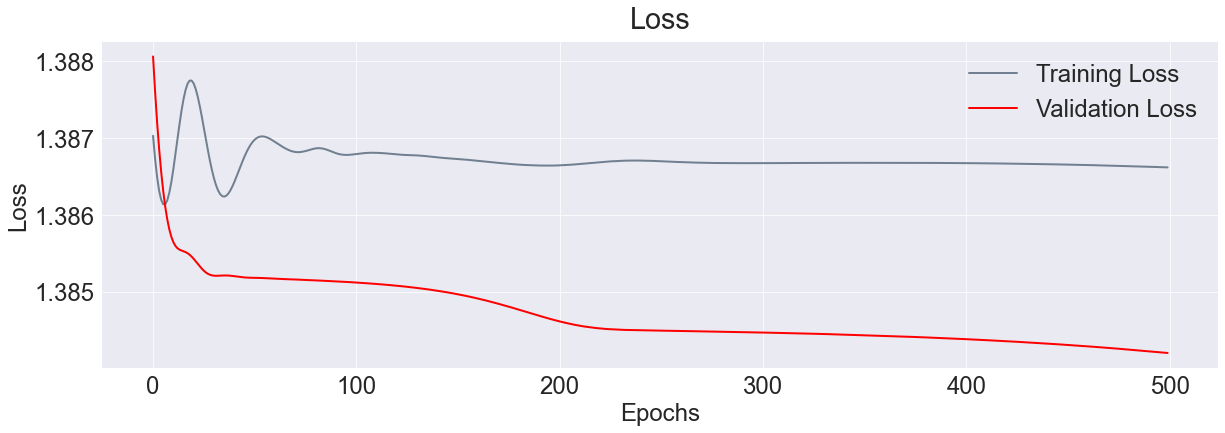

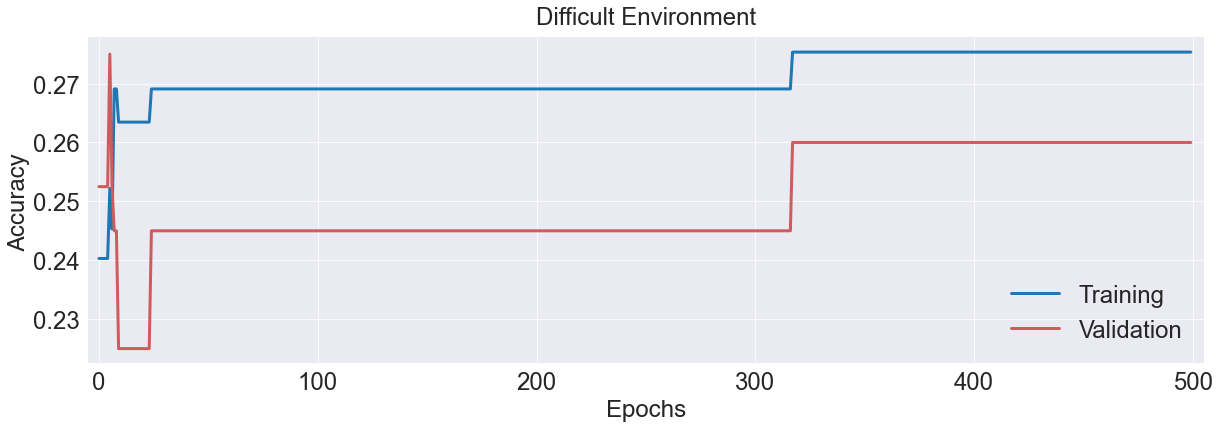


sequence lenth 11 difficult environment
Epoch: 0, train loss: 1.38699, train acc: 0.24717, test loss: 1.38568, test acc: 0.24874
Epoch: 25, train loss: 1.38147, train acc: 0.28113, test loss: 1.38725, test acc: 0.25628
Epoch: 50, train loss: 1.37595, train acc: 0.29182, test loss: 1.39024, test acc: 0.25377
Epoch: 75, train loss: 1.36708, train acc: 0.30314, test loss: 1.39401, test acc: 0.27889
Epoch: 100, train loss: 1.35420, train acc: 0.31950, test loss: 1.40704, test acc: 0.28894
Epoch: 125, train loss: 1.32115, train acc: 0.35535, test loss: 1.42001, test acc: 0.24874
Epoch: 150, train loss: 1.26887, train acc: 0.40440, test loss: 1.43479, test acc: 0.27136
Epoch: 175, train loss: 1.22046, train acc: 0.44528, test loss: 1.46069, test acc: 0.26382
Epoch: 200, train loss: 1.12697, train acc: 0.49623, test loss: 1.51945, test acc: 0.27638
Epoch: 225, train loss: 1.04316, train acc: 0.55723, test loss: 1.58103, test acc: 0.26884
Epoch: 250, train loss: 0.92178, train acc: 0.63145, t

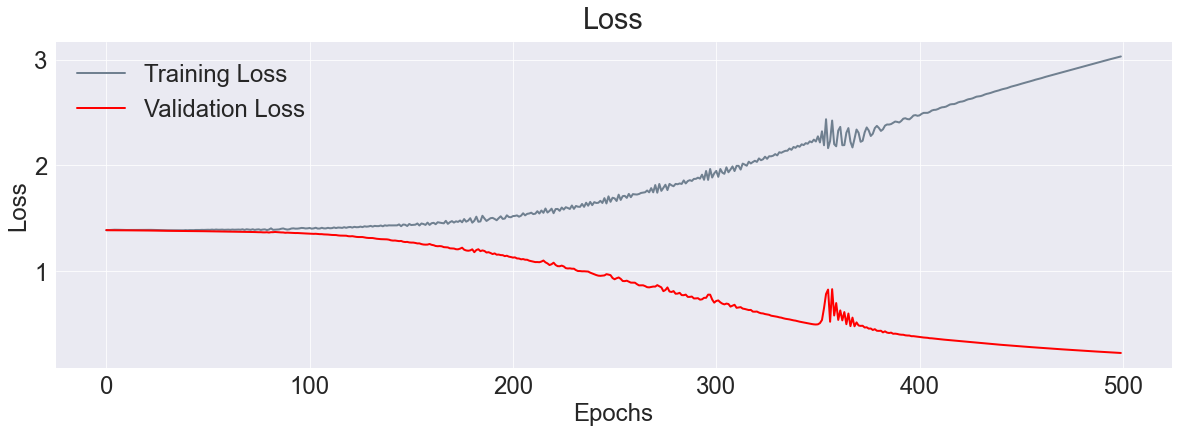

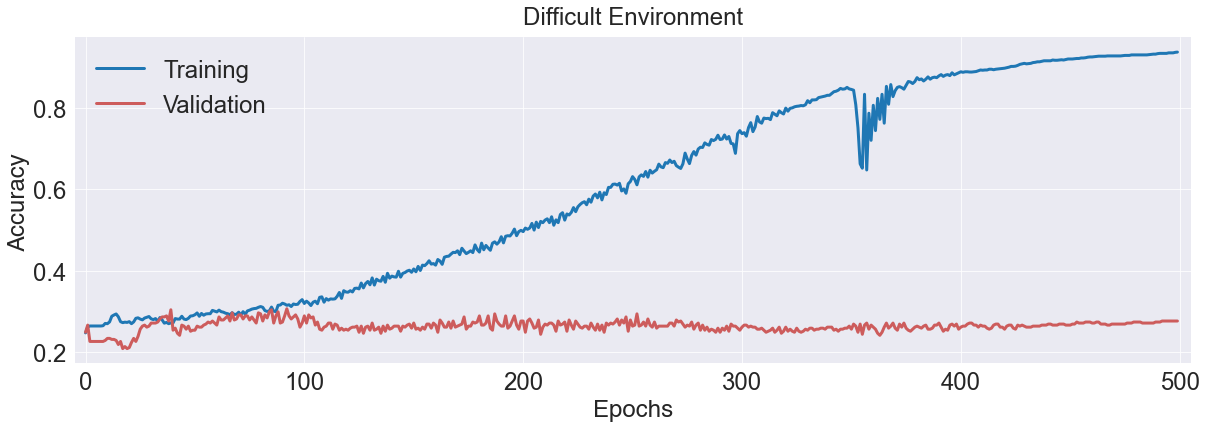


sequence lenth 21 difficult environment
Epoch: 0, train loss: 1.38692, train acc: 0.24083, test loss: 1.38593, test acc: 0.25505
Epoch: 25, train loss: 1.38200, train acc: 0.28192, test loss: 1.38593, test acc: 0.23990
Epoch: 50, train loss: 1.37701, train acc: 0.29077, test loss: 1.38920, test acc: 0.27525
Epoch: 75, train loss: 1.36401, train acc: 0.30152, test loss: 1.39354, test acc: 0.26010
Epoch: 100, train loss: 1.34794, train acc: 0.32301, test loss: 1.40383, test acc: 0.25000
Epoch: 125, train loss: 1.32399, train acc: 0.33186, test loss: 1.43039, test acc: 0.24242
Epoch: 150, train loss: 1.28548, train acc: 0.36599, test loss: 1.46942, test acc: 0.25253
Epoch: 175, train loss: 1.25668, train acc: 0.37611, test loss: 1.49440, test acc: 0.26515
Epoch: 200, train loss: 1.21412, train acc: 0.40455, test loss: 1.58307, test acc: 0.26768
Epoch: 225, train loss: 1.16887, train acc: 0.43363, test loss: 1.59024, test acc: 0.24747
Epoch: 250, train loss: 1.16579, train acc: 0.42920, t

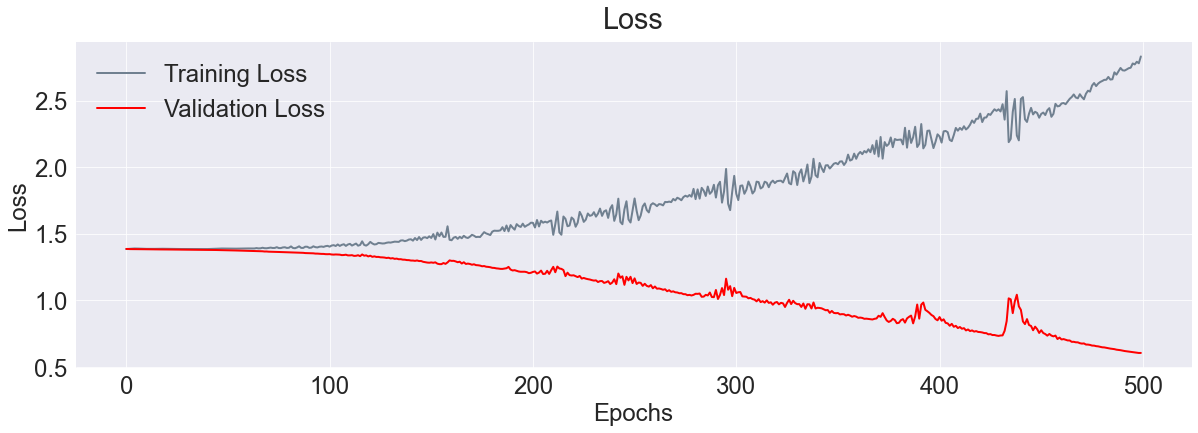

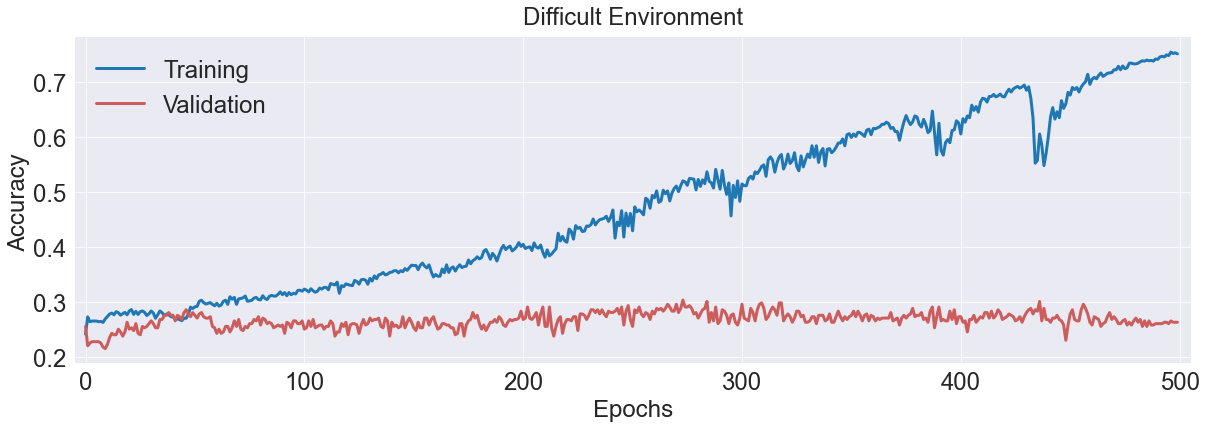

In [112]:
def run_all_environments(environments):

    meta_meta_train_acc_collector = []
    meta_meta_test_acc_collector = []
    
    for idx, data in enumerate(environments):
        
        num_epochs = 500
        learning_rate = 0.0001

        input_size = 1
        hidden_size = 300
        num_layers = 1

        num_classes = 4
        
        meta_train_acc_collector = []
        meta_test_acc_collector = []
        
        for i in range(1, 22, 10):

            print('')
            if idx == 0: print('sequence lenth', i, 'easy environment')
            if idx == 1: print('sequence lenth', i, 'medium environment')
            if idx == 2: print('sequence lenth', i, 'difficult environment')
            seq_length = i
            shuffle = True

            trainX, trainY, testX, testY = create_data(seq_length, data, shuffle = False)

            train_loss_collector, train_acc_collector, test_loss_collector, test_acc_collector = train_lstm(num_epochs, trainX, trainY, testX, testY)

            plot_losses(test_loss_collector, train_loss_collector, num_epochs)
            plot_euclidean_distance(train_acc_collector, test_acc_collector, num_epochs)

            meta_train_acc_collector.append(train_acc_collector)
            meta_test_acc_collector.append(test_acc_collector)
        
        meta_meta_train_acc_collector.append(meta_train_acc_collector)
        meta_meta_test_acc_collector.append(meta_test_acc_collector)

    return meta_meta_train_acc_collector, meta_meta_test_acc_collector

environments = [oracle_reversed_data, oracle_reversed_random_data_small, tmaze_random_reverse_data]

# 3 environments x 3 sequence lenghts x actual runs
train_distances, test_distances = run_all_environments(environments)



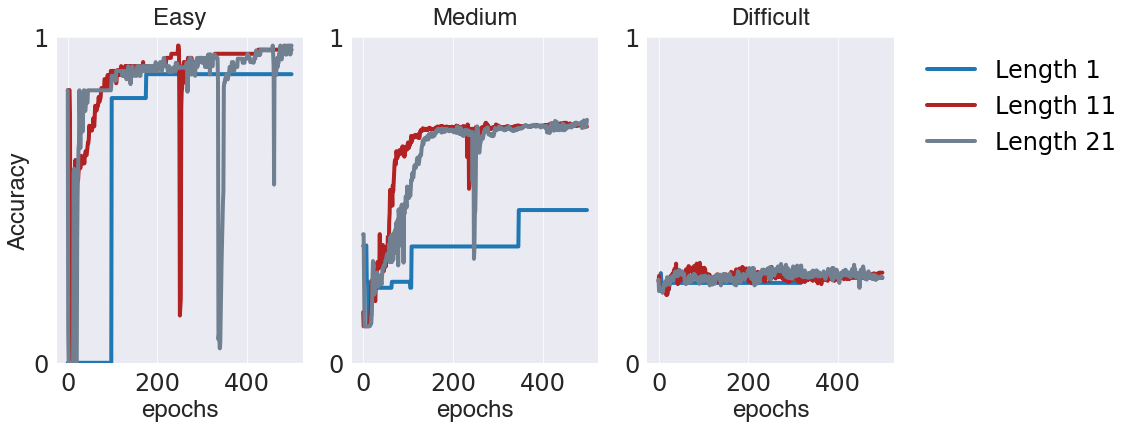

In [123]:
font = 24
hfont = {'fontname':'Helvetica'}

#plt.rcParams["figure.figsize"] = 25, 5.5
plt.rcParams.update({"font.size": font})
plt.rcParams['axes.titlepad'] = 13 
plt.rcParams['xtick.major.pad']='8' # axis distance
plt.rcParams['ytick.major.pad']='8'

plt.figure(figsize=(15, 6))

with plt.style.context("seaborn-darkgrid"):

    plt.rc("xtick", labelsize=font)
    plt.rc("ytick", labelsize=font)

    plt.title("Model performance", fontsize=font)
    plt.ylabel("validation accuracy", fontsize=font, **hfont)
    plt.xlabel("n-step distance", fontsize=font, **hfont)

    # easy
    plt.subplot(1, 3, 1)
    y1, = plt.plot(test_distances[0][0], linestyle='solid', c='tab:blue', label='Length 1', linewidth=4.0)
    y2, = plt.plot(test_distances[0][1], c='firebrick', linestyle='solid', label='Length 11', linewidth=4.0)
    y3, = plt.plot(test_distances[0][2], c='slategray', linestyle='solid', label='Length 21', linewidth=4.0)
    
    #plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.ylim(ymax = 1, ymin = 0)
    plt.yticks(np.arange(0, 1+0.1, 1))
    plt.ylabel("Accuracy", fontsize=font, **hfont)
    plt.xlabel("epochs", fontsize=font, **hfont)
    plt.title("Easy", fontsize=font, **hfont)
        
    plt.subplot(1, 3, 2)
    plt.plot(test_distances[1][0], linestyle='solid', c='tab:blue', label='Length 1', linewidth=4.0)
    plt.plot(test_distances[1][1], c='firebrick', linestyle='solid', label='Length 9', linewidth=4.0)
    plt.plot(test_distances[1][2], c='slategray', linestyle='solid', label='Length 17', linewidth=4.0)
    
    #plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.ylim(ymax = 1, ymin = 0)
    plt.yticks(np.arange(0, 1+0.1, 1))
    plt.xlabel("epochs", fontsize=font, **hfont)
    plt.title("Medium", fontsize=font, **hfont)

    plt.subplot(1, 3, 3)
    plt.plot(test_distances[2][0], linestyle='solid', c='tab:blue', label='Length 1', linewidth=4.0)
    plt.plot(test_distances[2][1], c='firebrick', linestyle='solid', label='Length 9', linewidth=4.0)
    plt.plot(test_distances[2][2], c='slategray', linestyle='solid', label='Length 17', linewidth=4.0)
    
    #plt.xticks(np.arange(min(x), max(x)+1, 1.0))
    plt.ylim(ymax = 1, ymin = 0)
    plt.yticks(np.arange(0, 1+0.1, 1))
    plt.xlabel("epochs", fontsize=font, **hfont)
    plt.title("Difficult", fontsize=font, **hfont)
    
plt.legend(handles=[y1, y2, y3], bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.savefig('lstm_action_pred_test.pdf', bbox_inches="tight")
plt.show()

In [122]:
plot_losses(test_loss_collector, train_loss_collector, num_epochs)
plot_euclidean_distance(train_acc_collector, test_acc_collector, num_epochs)

AttributeError: 'float' object has no attribute 'item'

In [29]:
print(len(predicted))
print(len(dataY))

labels = dataY.to(torch.long)
labels = labels[:, 0]

incorrect = [predicted == labels]
incorrect = incorrect[0].tolist()

2369
2369


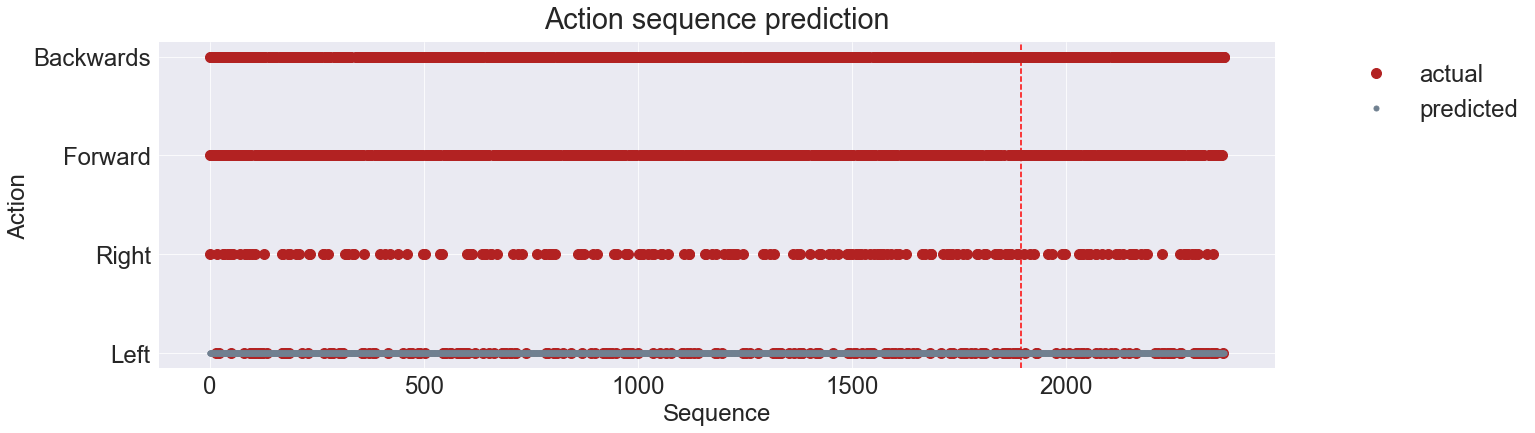

In [120]:
lstm.eval()
predict = lstm(dataX) # all data

_, predicted = torch.max(predict, 1)
data_predict = predicted.data.numpy()

dataY_plot = dataY.data.numpy()

font = 24
hfont = {'fontname':'Helvetica'}

plt.rcParams['axes.titlepad'] = 13 
plt.rcParams['xtick.major.pad']='8' # axis distance
plt.rcParams['ytick.major.pad']='8'
plt.rcParams.update({"font.size": 24})

with plt.style.context("seaborn-darkgrid"):
    plt.figure(figsize=(20, 6))
    
    plt.axvline(x=train_size, c="r", linestyle="--")

    plt.plot(dataY_plot, "o", color='firebrick', markersize=10, label="actual")
    plt.plot(data_predict, "o", color="slategray", markersize=5, label="predicted")
    
    plt.yticks([0, 1, 2, 3], ['Left', 'Right', 'Forward', 'Backwards'])

    # plt.legend(['Training Acc', 'Validation Acc'])
    #plt.legend(loc="lower right")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Action sequence prediction")
    plt.xlabel("Sequence", fontsize=font, **hfont)
    plt.ylabel("Action", fontsize=font, **hfont)
    plt.show()